# Import Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import random
import librosa, IPython
import librosa.display as lplt
import os, sys, cv2
import numpy as np
import pandas as pd
import IPython.display as ipd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, MaxPool1D, GaussianNoise, GlobalMaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold

# Data Preparation

In [13]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', figsize=(10, 8)):

    class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')  
    plt.yticks(rotation=0)  
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


## Extract features

In [7]:
import os

directory_path = '/kaggle/input/Data/genres_original'
print("Files in directory:", os.listdir(directory_path))

Files in directory: ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


In [14]:
import math

def get_mfccs(directory_path, fs=22050, duration=30, n_fft=2048, hop_length=512, n_mfcc=13, num_segments=10):
    # Initialize lists to store MFCCs, genre names, and genre numbers
    mfccs = []
    genre_names = []
    genre_nums = []

    # Calculate the number of samples per segment and the number of MFCC vectors per segment
    samples_per_track = fs * duration
    samples_per_segment = int(samples_per_track / num_segments)
    mfccs_per_segment = math.ceil(samples_per_segment / hop_length)

    print("MFCC collection started!")
    for i, (path_current, folder_names, file_names) in enumerate(os.walk(directory_path)):
        # Skip the parent directory
        if path_current == directory_path:
            continue

        # Extract genre name from the directory structure
        genre_current = os.path.basename(path_current)

        # Process each file in the genre folder
        for file in file_names:
            file_path = os.path.join(path_current, file)

            try:
                # Load audio data
                audio, fs = librosa.load(file_path, sr=fs)

                # Extract MFCCs for each segment
                for seg in range(num_segments):
                    start_sample = seg * samples_per_segment
                    end_sample = start_sample + samples_per_segment

                    # Compute MFCCs for the current segment
                    mfcc = librosa.feature.mfcc(y=audio[start_sample:end_sample], sr=fs, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
                    mfcc = mfcc.T  # Transpose to match the expected shape

                    # Append MFCCs and genre information if the shape matches
                    if len(mfcc) == mfccs_per_segment:
                        mfccs.append(mfcc.tolist())
                        genre_names.append(genre_current)
                        genre_nums.append(i - 1)  # Assign a numerical label to each genre

            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue

        print(f"Collected MFCCs for {genre_current.title()}!")
        
    print("MFCC collection complete!")
    # Convert lists to numpy arrays
    mfccs = np.array(mfccs)
    genre_names = np.array(genre_names)
    genre_nums = np.array(genre_nums)

    return mfccs, genre_names, genre_nums

In [15]:
n_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 1  
track_duration = 30  

directory_path = '/kaggle/input/Data/genres_original'

mfccs, genres, genre_nums = get_mfccs(directory_path,
                                      fs=22050,
                                      duration=track_duration,
                                      n_fft=n_fft,
                                      hop_length=hop_length,
                                      n_mfcc=n_mfcc,
                                      num_segments=num_segments)

# Print the shapes of the extracted data
print(f"MFCCs shape: {mfccs.shape}")
print(f"Genres shape: {genres.shape}")
print(f"Genre numbers shape: {genre_nums.shape}")

MFCC collection started!
Collected MFCCs for Disco!
Collected MFCCs for Metal!
Collected MFCCs for Reggae!
Collected MFCCs for Blues!
Collected MFCCs for Rock!
Collected MFCCs for Classical!


<ipython-input-14-1f833292d37a>:29: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(file_path, sr=fs)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file /kaggle/input/Data/genres_original/jazz/jazz.00054.wav: 
Collected MFCCs for Jazz!
Collected MFCCs for Hiphop!
Collected MFCCs for Country!
Collected MFCCs for Pop!
MFCC collection complete!
MFCCs shape: (998, 1292, 13)
Genres shape: (998,)
Genre numbers shape: (998,)


In [17]:
print(f"MFCCs: {mfccs.shape}")
print(f"genres: {genres.shape}")

MFCCs: (998, 1292, 13)
genres: (998,)


In [18]:
label_mapping = {
    'blues': 0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop': 7,
    'reggae': 8,
    'rock': 9
}

genre_indices = np.array([label_mapping[label] for label in genres])

print(f"Original genres: {genres}")
print(f"Converted genre indices: {genre_indices}")

Original genres: ['disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco' 'disco'
 'disco' 'metal' 'metal' 'metal' 'metal' 'metal' 'metal' 'metal' 'metal'
 'metal' 'metal' 'metal' 'metal' 'metal' 'metal' 'metal' 'metal' 'metal'
 'metal' 'metal' 'metal' 'metal' '

In [19]:
X = np.array(mfccs)
y = np.array(genre_indices)

## Split Train, Test Sets

In [20]:
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (638, 1292, 13), y training data shape: (638,)
X validation data shape: (160, 1292, 13), y validation data shape: (160,)


In [21]:
# Add additional dimension for CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape 

(638, 1292, 13, 1)

# CNN Model


## 1-block CNN

In [22]:
model_cnn1 = Sequential()

model_cnn1.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))  # 卷积层
model_cnn1.add(MaxPooling2D((2, 2), padding='same'))  # 池化层

model_cnn1.add(Flatten())

model_cnn1.add(Dense(64, activation='relu'))  # 隐藏层
model_cnn1.add(Dense(10, activation='softmax'))  # 输出层，10个类别

model_cnn1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1290, 11, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 645, 6, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 123840)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       7,925,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,926,794 (30.24 MB)

 Trainable params: 7,926,794 (30.24 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [25]:
hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - acc: 0.1010 - loss: 55.7283 - val_acc: 0.1000 - val_loss: 58.7843
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.1247 - loss: 46.1164 - val_acc: 0.1750 - val_loss: 13.0132
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.2052 - loss: 9.2715 - val_acc: 0.1063 - val_loss: 2.3113
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.0951 - loss: 2.3060 - val_acc: 0.1000 - val_loss: 2.3026
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.1160 - loss: 2.3022 - val_acc: 0.1000 - val_loss: 2.3026
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1057 - loss: 2.3020 - val_acc: 0.1000 - val_loss: 2.3026
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.0922 - loss: 2.2971 - val_acc: 0.1000 - val_loss: 2.3026
Epoch 8/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.0869 - loss: 2.3018 - val_acc: 0.1000 - val_loss: 2.3026
Epoch 9/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

In [27]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.0868 - loss: 2.2993 
Test Loss: 2.2998571395874023
Test Accuracy: 0.10499999672174454


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


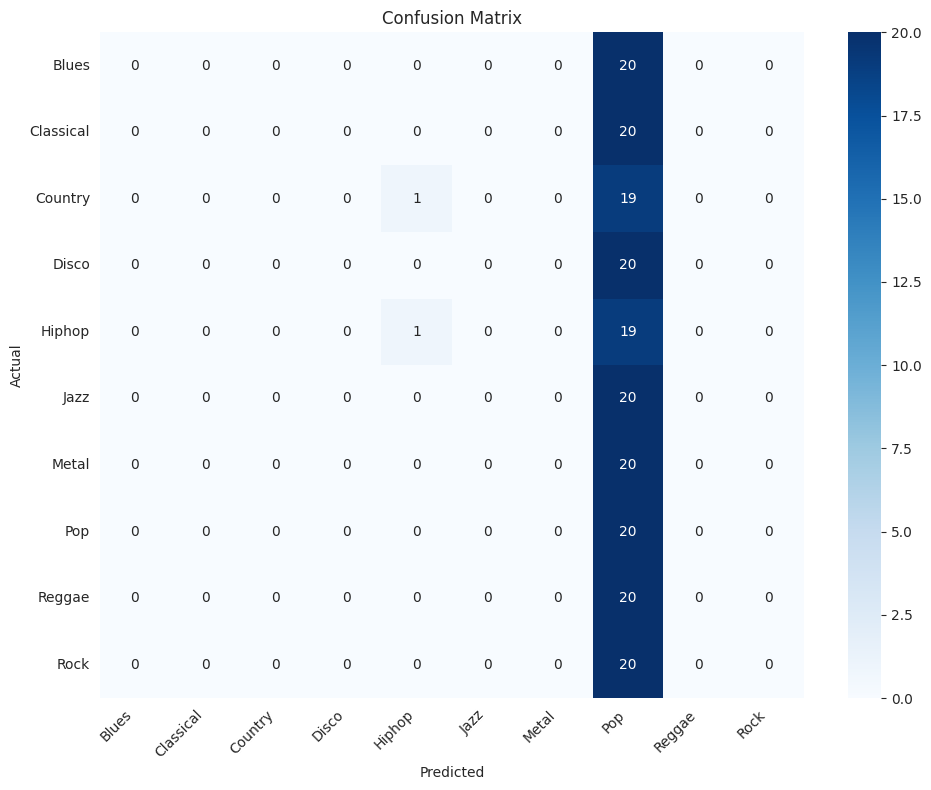


Classification Report:

              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00        20
   Classical       0.00      0.00      0.00        20
     Country       0.00      0.00      0.00        20
       Disco       0.00      0.00      0.00        20
      Hiphop       0.50      0.05      0.09        20
        Jazz       0.00      0.00      0.00        20
       Metal       0.00      0.00      0.00        20
         Pop       0.10      1.00      0.18        20
      Reggae       0.00      0.00      0.00        20
        Rock       0.00      0.00      0.00        20

    accuracy                           0.10       200
   macro avg       0.06      0.11      0.03       200
weighted avg       0.06      0.10      0.03       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
y_pred = model_cnn1.predict(X_test_cnn)

y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = y_test 

plot_confusion_matrix(y_test_classes, y_pred_classes, title='Confusion Matrix')

##  3-block CNN


In [30]:
model_cnn2 = Sequential()

model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) 
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same')) 


model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(64, activation='relu'))

# output to 10 classes for predictions
model_cnn2.add(Dense(10, activation='softmax'))
model_cnn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1290, 11, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 645, 6, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 123840)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       7,925,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,780,384 (90.71 MB)

 Trainable params: 7,926,794 (30.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,853,590 (60.48 MB)

In [31]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [32]:
hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - acc: 0.1210 - loss: 4.4395 - val_acc: 0.2125 - val_loss: 2.5570
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.2232 - loss: 2.3452 - val_acc: 0.2188 - val_loss: 2.2841
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.2596 - loss: 2.0264 - val_acc: 0.2562 - val_loss: 2.1162
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.3373 - loss: 1.8214 - val_acc: 0.2625 - val_loss: 2.0846
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.3912 - loss: 1.6988 - val_acc: 0.3625 - val_loss: 1.9158
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.4110 - loss: 1.6162 - val_acc: 0.4000 - val_loss: 1.8679
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.4567 - loss: 1.4780 - val_acc: 0.4062 - val_loss: 1.8126
Epoch 8/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.5200 - loss: 1.3680 - val_acc: 0.4250 - val_loss: 1.7721
Epoch 9/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - a

In [33]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - acc: 0.4628 - loss: 2.7453
Test Loss: 2.5696022510528564
Test Accuracy: 0.5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


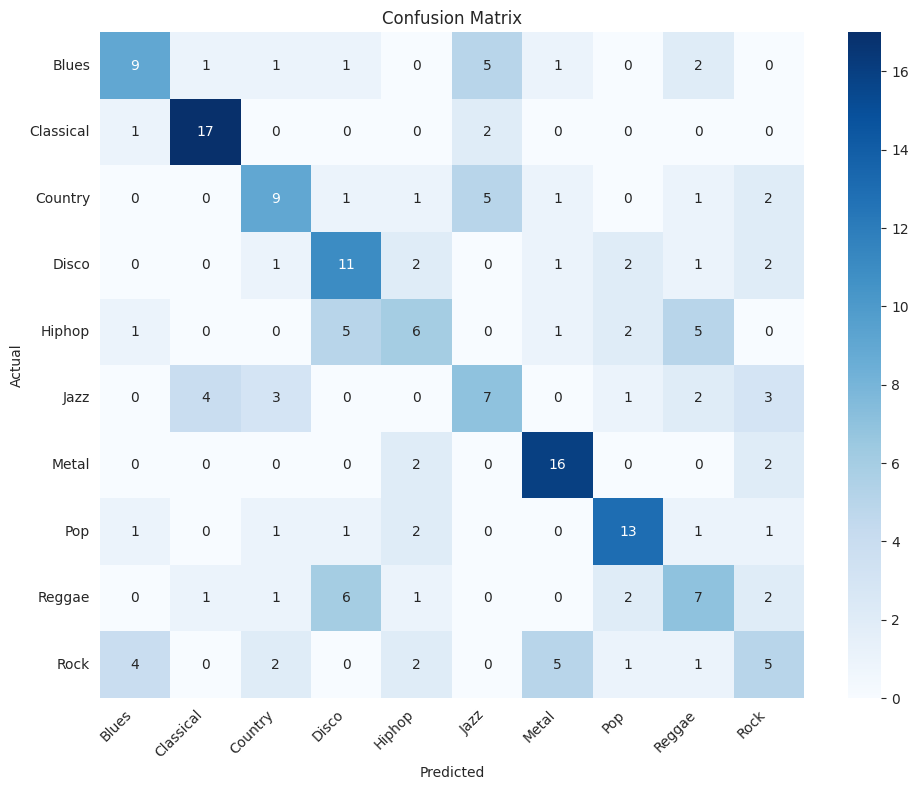


Classification Report:

              precision    recall  f1-score   support

       Blues       0.56      0.45      0.50        20
   Classical       0.74      0.85      0.79        20
     Country       0.50      0.45      0.47        20
       Disco       0.44      0.55      0.49        20
      Hiphop       0.38      0.30      0.33        20
        Jazz       0.37      0.35      0.36        20
       Metal       0.64      0.80      0.71        20
         Pop       0.62      0.65      0.63        20
      Reggae       0.35      0.35      0.35        20
        Rock       0.29      0.25      0.27        20

    accuracy                           0.50       200
   macro avg       0.49      0.50      0.49       200
weighted avg       0.49      0.50      0.49       200



In [34]:
y_pred = model_cnn2.predict(X_test_cnn)

y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = y_test 

plot_confusion_matrix(y_test_classes, y_pred_classes, title='Confusion Matrix')

## 3-block CNN with Regulation

BatchNormalization and Dropout are used, which help improve the stability and generalization of the model.

A larger fully connected layer (128 neurons) is used to increase the expressiveness of the model.

In [35]:
model_cnn3 = Sequential()

# Create a convolution block
model_cnn3.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn3.add(Dropout(0.2))

# Add another conv block
model_cnn3.add(Conv2D(64, 3, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Add another conv block
model_cnn3.add(Conv2D(64, 2, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu'))
model_cnn3.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn3.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification
model_cnn3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 1290, 11, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1290, 11, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 645, 6, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 645, 6, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 643, 4, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 643, 4, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 322, 2, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 322, 2, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 321, 1, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 321, 1, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 161, 1, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 161, 1, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 10304)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,319,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,356,234 (5.17 MB)

 Trainable params: 1,355,914 (5.17 MB)

 Non-trainable params: 320 (1.25 KB)

In [36]:
model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [37]:
# Create an early stopping callback
es_cnn3 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0) 
# Train the model
hist_cnn3 = model_cnn3.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
#     callbacks=[es_cnn2]
)

Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 566ms/step - acc: 0.1148 - loss: 3.9932 - val_acc: 0.1625 - val_loss: 4.3382
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.2376 - loss: 2.6479 - val_acc: 0.2062 - val_loss: 2.7742
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.3436 - loss: 2.0983 - val_acc: 0.2375 - val_loss: 2.4430
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.3530 - loss: 1.9564 - val_acc: 0.2188 - val_loss: 2.5270
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.3924 - loss: 1.8518 - val_acc: 0.2562 - val_loss: 2.4017
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.4395 - loss: 1.5770 - val_acc: 0.2562 - val_loss: 2.1969
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.4669 - loss: 1.5501 - val_acc: 0.3000 - val_loss: 2.0643
Epoch 8/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.4765 - loss: 1.4749 - val_acc: 0.3500 - val_loss: 1.9865
Epoch 9/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - 

In [38]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - acc: 0.5651 - loss: 2.8579
Test Loss: 2.7483718395233154
Test Accuracy: 0.5849999785423279


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


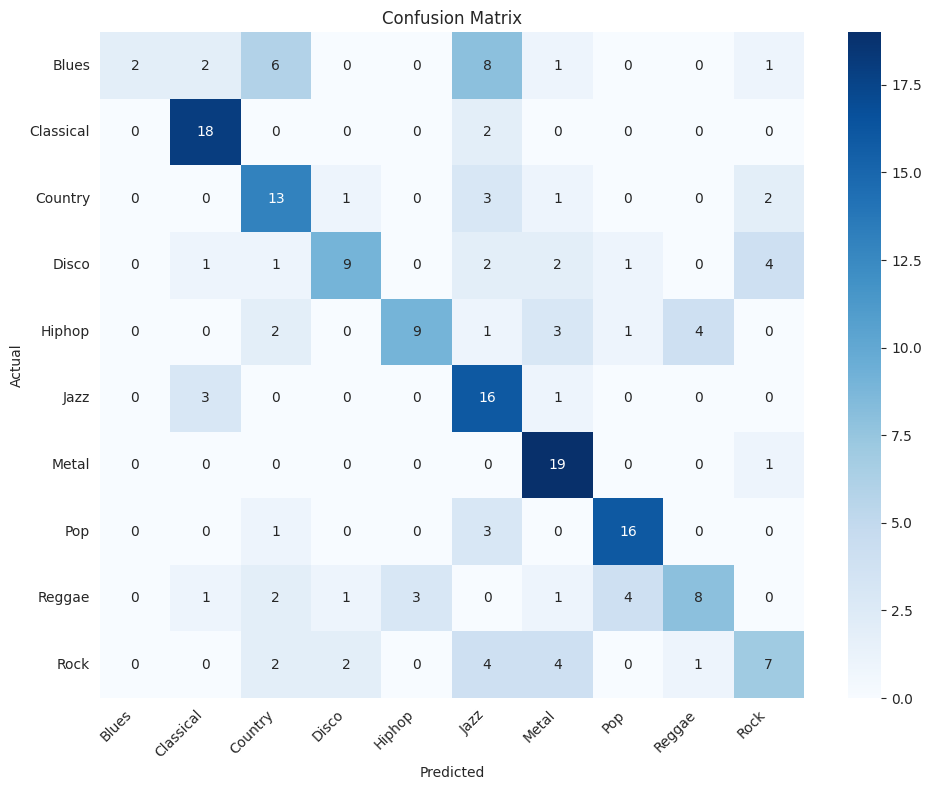


Classification Report:

              precision    recall  f1-score   support

       Blues       1.00      0.10      0.18        20
   Classical       0.72      0.90      0.80        20
     Country       0.48      0.65      0.55        20
       Disco       0.69      0.45      0.55        20
      Hiphop       0.75      0.45      0.56        20
        Jazz       0.41      0.80      0.54        20
       Metal       0.59      0.95      0.73        20
         Pop       0.73      0.80      0.76        20
      Reggae       0.62      0.40      0.48        20
        Rock       0.47      0.35      0.40        20

    accuracy                           0.58       200
   macro avg       0.65      0.58      0.56       200
weighted avg       0.65      0.58      0.56       200



In [39]:
y_pred = model_cnn3.predict(X_test_cnn)

y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = y_test 

plot_confusion_matrix(y_test_classes, y_pred_classes, title='Confusion Matrix')